In [105]:
import pandas as pd
import numpy as np
import scipy.stats

import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
import seaborn as sns
%matplotlib inline

from ipywidgets import interactive
import ipywidgets as widgets

# Introduction to Linear Regression

This is to follow the book: http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf

* Is there a relationship between advertising budget and sales?
* How strong is the relationship between advertising budget and sales?
* Which media contribute to sales?
* How accurately can we estimate the effect of each medium on sales?
* How accurately can we predict future sales?
* Is the relationship linear?
* Is there synergy among the advertising media?

$y \approx \beta_0+\beta_1*X$

$\hat{y} = \hat{\beta}_0+\hat{\beta}_1*X$

In [106]:
df = pd.read_csv(r'C:\Users\anton.bezuglov\Documents\notebooks\data200_notebooks\data\Advertising.csv')
df.head()

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


## Estimating the coefficients

Mean Squared Error approach -- minimize the average squared difference between a point and linear regression.

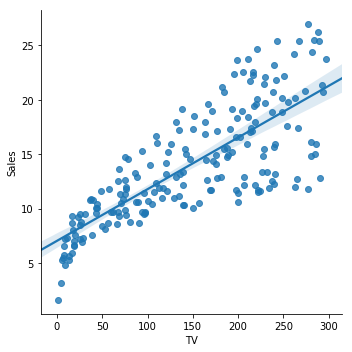

In [107]:
sns.lmplot(x = 'TV', y = 'Sales', data = df)

Experiment with the coefficients below to minimize RSS:

In [108]:
X = df['TV']
y = df['Sales']

In [109]:
def linear_fit(b0,b1):
    y_hat = b0+b1*X
    RSS = np.sum((y_hat-y)**2)
    
    fig = plt.figure(figsize = (10,5))
    ax = fig.add_subplot(1,2,1)
    ax.plot(X, y_hat, label = '$\hat{y}$', color = 'b')
    ax.scatter(X, y, label = 'Sales')
    ax.set_xlabel('TV')
    ax.set_ylabel('Sales')
    ax.set_title('RSS = %.2f'%RSS)
    ax.legend()
    
    ax = fig.add_subplot(1,2,2)
    sns.distplot(y_hat-y, ax = ax)
    ax.set_title('Error Distribution')
    ax.set_xlabel('$\hat{y}-y$')
    plt.show()
    
i_plot = interactive(linear_fit, b1 = (0.0,0.1,0.005), b0 = (0.0,10.0))
i_plot

interactive(children=(FloatSlider(value=5.0, description='b0', max=10.0), FloatSlider(value=0.05, description=…

According to the least squares approach, the equations for $\hat{\beta}_1$ and $\hat{\beta}_0$ are: 

$\hat{\beta}_1 = \frac{\sum_{i=1}^{n}(x_i-\bar{x})(y_i-\bar{y})}{\sum_{i=1}^{n}(x_i-\bar{x})^2}$

$\hat{\beta}_0 = \bar{y}-\hat{\beta}_1\bar{x}$

In [110]:
def least_squares_estimate(X,y):
    b1_hat = np.sum((X-np.mean(X))*(y-np.mean(y)))/np.sum((X-np.mean(X))**2)
    b0_hat = np.mean(y)-b1_hat*np.mean(X)
    return b0_hat, b1_hat

least_squares_estimate(X,y)

(7.032593549127698, 0.047536640433019736)

## Assessing the Accuracy of the Coefficients

The assumption is that the *true* relationship between X and y takes the form $y = f(X)+\epsilon$, where $\epsilon$ is a mean-zero random error term:

$y = \beta_0+\beta_1X+\epsilon$

Let us illustrate this with simulated data:

In [111]:
X = np.arange(-2,2,0.05)
y = 2 + 3*X + np.random.normal(0,5,X.shape)

b0_hat, b1_hat = least_squares_estimate(X,y)

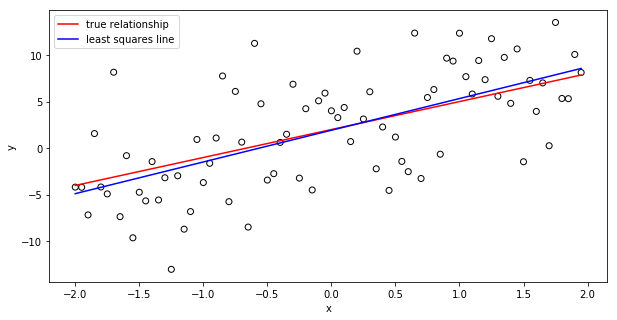

In [112]:
plt.figure(figsize = (10,5))
plt.scatter(X,y,facecolors='none', edgecolors='black', 
            color = 'black')
plt.xlabel('x')
plt.ylabel('y')
plt.plot(X,2+3*X, color = 'red', label = 'true relationship')
plt.plot(X,b0_hat+b1_hat*X, color = 'blue', label = 'least squares line')
plt.legend()
plt.show()

At this time, let us compute $\beta_0$ and $\beta_1$ based on sample of data:

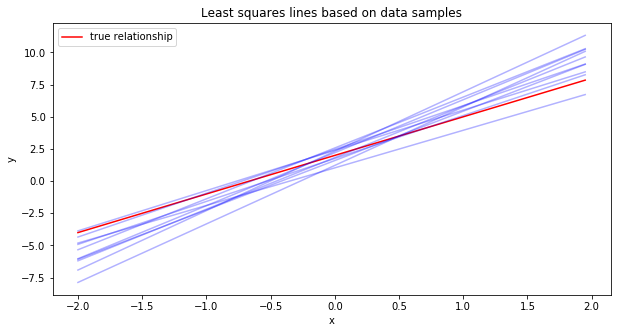

In [113]:
betas = []
num_tries = 10 # number of estimates
for _ in range(num_tries):
    indices = np.random.choice(X.shape[0]
                               ,size = round(0.4*X.shape[0]) # 0.4 -- sample size, 40% of the data
                               ,replace = False )
    betas.append(least_squares_estimate(X[indices],y[indices]))

plt.figure(figsize = (10,5))
plt.xlabel('x')
plt.ylabel('y')
plt.plot(X,2+3*X, color = 'red', label = 'true relationship')
for (b0_hat,b1_hat) in betas:
    plt.plot(X,b0_hat+b1_hat*X, color = 'blue', alpha = 0.3)
plt.title('Least squares lines based on data samples')
plt.legend()
plt.show()

The standard errors of $\beta_0$ and $\beta_1$ are as follows:

$SE(\hat{\beta}_0)^2 = \sigma^2\left[1/n+\frac{\bar{x}^2}{\sum_{i=1}^n\left(x_i-\bar{x}\right)^2}\right]$

$SE(\hat{\beta}_1)^2 = \frac{\sigma^2}{\sum_{i=1}^n\left(x_i-\bar{x}\right)^2}$

where $\sigma^2 = Var(\epsilon)$ that can be estimated as residual standard error (RSE):

$\sigma = RSE = \sqrt{RSS/(n-2)}$

95% confidence intervals are:
$\left[\hat{\beta}_0-2*SE(\hat{\beta}_0),\hat{\beta}_0+2*SE(\hat{\beta}_0)\right]$

$\left[\hat{\beta}_1-2*SE(\hat{\beta}_1),\hat{\beta}_1+2*SE(\hat{\beta}_1)\right]$

In [114]:
def standard_errors(betas,X,y):
    b0_hat, b1_hat = betas[0], betas[1]
    y_hat = b0_hat+b1_hat*X
    RSS = np.sum((y_hat-y)**2)
    var_e = RSE_squared = (RSS/(X.shape[0]-2))
    SE_b0 = (var_e*(1/X.shape[0]+np.mean(X)**2/np.sum((X-np.mean(X))**2)))**0.5
    SE_b1 = (var_e/np.sum((X-np.mean(X))**2))**0.5
    return SE_b0, SE_b1

betas = least_squares_estimate(X,y)
SE = standard_errors(betas,X,y)
print(SE)
print("Beta 95% confidence intervals: ")
print("\tBeta 0: [%.3f,%.3f]"%(betas[0]-2*SE[0],betas[0]+2*SE[0]))
print("\tBeta 1: [%.3f,%.3f]"%(betas[1]-2*SE[1],betas[1]+2*SE[1]))

(0.530052669016063, 0.4589673686620553)
Beta 95% confidence intervals: 
	Beta 0: [0.863,2.983]
	Beta 1: [2.483,4.319]


Let us get back to our original dataset (Advertising):

In [115]:
X = df['TV']
y = df['Sales']
betas = least_squares_estimate(X,y)

print(betas)

SE = standard_errors(betas,X,y)
print(SE)

print("Beta 95% confidence intervals: ")
print("\tBeta 0: [%.3f,%.3f]"%(betas[0]-2*SE[0],betas[0]+2*SE[0]))
print("\tBeta 1: [%.3f,%.3f]"%(betas[1]-2*SE[1],betas[1]+2*SE[1]))

(7.032593549127698, 0.047536640433019736)
(0.4578429402734785, 0.0026906071877968707)
Beta 95% confidence intervals: 
	Beta 0: [6.117,7.948]
	Beta 1: [0.042,0.053]


In summary, in the absence of TV advertising, on average, the sales will be between 6,117 and 7,948 units. Every 1,000 increase in TV advertising will result in increase in sales of between 42 and 53 units. 

### Hypothesis tests on the coefficients

H0: There is no relationship between X and y
Ha: There is some relationship between X and y

H0: $\beta_1 = 0$
Ha: $\beta_1 0$

t-statistics:

$t = \frac{\hat{\beta}_1}{SE(\hat{\beta}_1}$

In [116]:
betas, SE

((7.032593549127698, 0.047536640433019736),
 (0.4578429402734785, 0.0026906071877968707))

In [117]:
t_stat = tuple([betas[i]/SE[i] for i in range(len(betas))])
t_stat

(15.360275174117556, 17.66762560087554)

Probability of getting these values randomly:

In [118]:
p_values = tuple([(1-scipy.stats.norm(0,1).cdf(np.abs(t)))*2 for t in t_stat])
p_values

(0.0, 0.0)

Let us make a function to compute simple linear regression statistics:

In [119]:
def simple_regression_stats(X,y):
    betas = least_squares_estimate(X,y)
    SE = standard_errors(betas,X,y)
    t_stat = tuple([betas[i]/SE[i] for i in range(len(betas))])
    p_values = tuple([(1-scipy.stats.norm(0,1).cdf(np.abs(t)))*2 for t in t_stat])
    return dict({'coefficients':betas
                ,'std. errors':SE
                ,'t-statistic':t_stat
                ,'p-values':p_values})
simple_regression_stats(X,y)

{'coefficients': (7.032593549127698, 0.047536640433019736),
 'std. errors': (0.4578429402734785, 0.0026906071877968707),
 't-statistic': (15.360275174117556, 17.66762560087554),
 'p-values': (0.0, 0.0)}

We conclude that neither slope nor intercept are zeros, i.e. *reject the null hypothesis*:

 || Coefficient | Std. Error | t-statistic | p-value |
 |-|-------------|------------|-------------|-------- |
 |Intercept|7.0326|0.4578|15.3603|<0.0001|
 |Slope|0.0475|0.0027|17.6676|<0.0001|

## Assessing the Accuracy of the Model

Once we have rejected the null hypothesis, we need to estimate how accurate the model is

### Residual Standard Error

$RSE = \sqrt{\frac{RSS}{n-2}}$

$RSS = \sum_{i=1}^n\left(y_i-\hat{y}_i\right)^2$

In [47]:
betas = least_squares_estimate(X,y)
b0_hat, b1_hat = betas[0], betas[1]
y_hat = b0_hat+b1_hat*X
RSS = np.sum((y-y_hat)**2)
RSE = np.sqrt(RSS/(X.shape[0]-2))
print("RSE: %.2f"%RSE)

RSE: 3.26


RSE is considered the *lack of fit* to the data

### $R^2$ Statistic

RSE provides the goodness of fit in the *units* of data and so it is not always clear what constitutes a good model. $R^2$ is a proportion of variance in the data explained by the model.

$R^2 = \frac{TSS-RSS}{TSS} = 1 - \frac{RSS}{TSS}$, where $TSS = \sum_{i=1}^{n}\left(y_i-\bar{y}\right)^2$

In [48]:
TSS = np.sum((y-np.mean(y))**2)
R2 = 1 - RSS/TSS
print("R^2: %.2f"%R2)

R^2: 0.61


In fact, in case of a univariate linear regression $\sqrt{R^2}$ equals to the correlation coefficient between X and y:

In [49]:
np.corrcoef(X,y)[0][1], np.sqrt(R2)

(0.7822244248616067, 0.7822244248616065)

# Multiple Linear Regression

In case of multiple inputs (TV, Radio, and Newspaper), there are two problems:

1. It is unclear how to make a single prediction, from multiple regressions
2. The model does not consider cross input effects

Below are three single regressions:

In [50]:
simple_regression_stats(df['TV'],df['Sales'])

{'coefficients': (7.032593549127698, 0.047536640433019736),
 'std. errors': (0.4578429402734785, 0.0026906071877968707),
 't-statistic': (15.360275174117556, 17.66762560087554),
 'p-values': (0.0, 0.0)}

In [51]:
simple_regression_stats(df['Radio'],df['Sales'])

{'coefficients': (9.311638095158282, 0.20249578339243965),
 'std. errors': (0.5629004962718714, 0.020411306360090635),
 't-statistic': (16.542245311258203, 9.920765472824959),
 'p-values': (0.0, 0.0)}

In [54]:
simple_regression_stats(df['Newspaper'],df['Sales'])

{'coefficients': (12.351407069278164, 0.05469309847227334),
 'std. errors': (0.6214201876094345, 0.016575721876358165),
 't-statistic': (19.876095620248954, 3.2995907436334173),
 'p-values': (0.0, 0.0004841295909323584)}

Rather, the model should look like:

$y = \beta_0+\beta_1*X_1+\beta_2*X_2+\beta_3*X_3+\epsilon$

... and coefficient estimates:

$\hat{y} = \hat{\beta}_0+\hat{\beta}_1*X_1+\hat{\beta}_2*X_2+\hat{\beta}_3*X_3$

To compute $\hat{\beta}$, modify the data by adding column 0 for the intercept and apply linear algebra:

$\hat{\beta} = \left(X^TX\right)^{-1}X^Ty$

In [73]:
X = np.ones([df[['TV','Radio','Newspaper']].shape[0],4]) # add an extra column = 1 for the intercept
X[:,1:] = df[['TV','Radio','Newspaper']]
y = df['Sales']

In [75]:
XT = np.transpose(X)
XTX = np.dot(XT,X)
beta = np.dot(np.dot(np.linalg.inv(XTX),XT),y)
beta

array([ 2.93888937e+00,  4.57646455e-02,  1.88530017e-01, -1.03749304e-03])

Model output is now: $\hat{y} = X\cdot\beta$, and the residual standard error is computed as usual:

In [80]:
y_hat = np.dot(X, beta)
RSS = np.sum((y-y_hat)**2)
RSE = np.sqrt(RSS/(X.shape[0]-2))
print("RSE: %.2f"%RSE)

RSE: 1.68


In [81]:
TSS = np.sum((y-np.mean(y))**2)
R2 = 1 - RSS/TSS
print("R^2: %.2f"%R2)

R^2: 0.90


To test the hypothesis whether any $\beta$ equals to 0, compute the standardized coefficient, $Z$ score:

$z_j = \frac{\hat{\beta}_j}{\hat{\sigma}\sqrt{v_j}}$

where

$v = diag\left(X^TX\right)^{-1}$, $\sigma^2 = \frac{1}{n-2-p}RSS$, $p = 3$ since we use three fields: TV, Radio, and Newspaper:

In [92]:
var_e = (1/(X.shape[0]-2-3))*RSS # sigma^2
var_e

2.855514168729165

In [94]:
v = np.diag(np.linalg.inv(XTX))
t_stat = beta/(np.sqrt(var_e)*np.sqrt(v))
t_stat

array([ 9.39822125, 32.72482193, 21.83757388, -0.17626321])

In [100]:
p_values = tuple([scipy.stats.chi2(X.shape[0]-2-3).cdf(np.abs(t)) for t in t_stat])
p_values

(3.3400026129847223e-90,
 2.210689340922534e-42,
 3.571006045348321e-57,
 1.3622297201598198e-256)

In [103]:
p_values = tuple([(1-scipy.stats.norm(0,1).cdf(np.abs(t)))*2 for t in t_stat])
p_values

(0.0, 0.0, 0.0, 0.8600871655477074)